In [2]:
import glob, h5py, math, time, os, json, sys
from scipy.stats import norm, expon, chi2, uniform, chisquare, beta
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

In [545]:
signal_type_dict = {
    4: r'$LQ \rightarrow b\tau$',
    5: r'$A \rightarrow 4l$',
    6: r'$h^{\pm} \rightarrow \tau\nu$',
    7: r'$h^0 \rightarrow \tau\tau$',
}
def Z_score_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def p_value_chi2(t,df):
    sf = chi2.sf(t, df)
    return sf

def Z_score_norm(t,mu, std):
    sf = norm.sf(t, mu, std)
    Z  = -norm.ppf(sf)
    return Z

def ClopperPearson_interval(total, passed, level):
    low_b, up_b = 0.5*(1-level), 0.5*(1+level)
    low_q=beta.ppf(low_b, passed, total-passed+1, loc=0, scale=1)
    up_q=beta.ppf(up_b, passed, total-passed+1, loc=0, scale=1)
    return np.around(passed*1./total-low_q, 5), np.around(up_q-passed*1./total,5)

def z_to_p(z):
    return norm.sf(z)

def p_to_z(pvals):
    return norm.ppf(1 - pvals)
    
def power_emp(t_ref,t_data,zalpha=[1,2,3]):
    alpha = z_to_p(zalpha)
    #print(alpha)
    quantiles = np.quantile(t_ref,1-alpha,method='higher')
    total = len(t_data) 
    passed_list = [np.sum(t_data>=quantile) for quantile in quantiles]
    err_list = [ClopperPearson_interval(total, passed, level=0.68) for passed in passed_list]
    power_list = [passed/total for passed in passed_list]
    return p_to_z(alpha), power_list, err_list

def power_asympt_chi2(t_ref,t_data,df,zalpha=[1,2,3]):
    alpha = z_to_p(zalpha)
    #print(alpha)
    quantiles = chi2.ppf(1-alpha,df)
    total = len(t_data) 
    passed_list = [np.sum(t_data>=quantile) for quantile in quantiles]
    err_list = [ClopperPearson_interval(total, passed, level=0.68) for passed in passed_list]
    power_list = [passed/total for passed in passed_list]
    return p_to_z(alpha), power_list, err_list

def plot_1distribution(t, df, xmin=0, xmax=300, nbins=10, save=False, ymax=None, output_path='', save_name='', label=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!). 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    label  = 'sample %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if ymax !=None:
        plt.ylim(0., ymax)
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_distribution.pdf')
            print('saved at %s'%(output_path+ save_name+'_distribution.pdf'))
    plt.show()
    plt.close(fig)
    return

def plot_2distribution(t1, t2, df, xmin=0, xmax=300, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True, title='Title', signal_type=4, injection_ratio=1, embedding_type="57D source"):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    Z_obs     = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t1)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t1)-t_obs_err, df)
    #label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    label  = '%s \nt = %s\n'%(label1, f'{int(np.around(np.median(t1), 0))}±{int(np.around(np.std(t1), 0))}')
    if print_Zscore:
        #label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_obs     = Z_score_chi2(np.median(t2), df)
    t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t2)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t2)-t_obs_err, df)
    p_obs = p_value_chi2(np.median(t2), df)
    p_obs_p = p_value_chi2(np.median(t2)+t_obs_err, df)
    p_obs_m = p_value_chi2(np.median(t2)-t_obs_err, df)
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    #label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2+f' ({signal_type_dict[signal_type]} {injection_ratio}%)', t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    label  = '%s \nt = %s\n'%(label2+f' ({signal_type_dict[signal_type]} {injection_ratio}%)', f'{int(np.around(np.median(t2), 0))}±{int(np.around(np.std(t2), 0))}')
    if print_Zscore:
        #label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        #label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=18) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=28, fontname="serif")
    plt.ylabel('Probability', fontsize=28, fontname="serif")
    plt.text(0.65,0.35,embedding_type,transform=plt.gca().transAxes, fontsize=18, fontname="serif", verticalalignment="top")
    #plt.title(title, fontsize=32)
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            os.makedirs(output_path, exist_ok=True)
            plt.savefig(os.path.join(output_path, save_name+'_2distribution.pdf'), bbox_inches="tight")
    plt.show()
    plt.close()
    return [Z_obs, Z_obs_p, Z_obs_m], [Z_empirical, Z_empirical_p, Z_empirical_m], [p_obs, p_obs_p, p_obs_m]

def plot_2distribution_new(t1, t2, df, xmin=0, xmax=300, ymax=None, nbins=10, Z_print=[1,2,3], 
                           return_power=True, save=False, output_path='', label1='1', label2='2', 
                           save_name='', print_Zscore=True, signal_type=4, injection_ratio=1, embedding_type="57D source"):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    Z_print: values of the Z-score for which to compute the power
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    ax= fig.add_axes([0.07, 0.07, 0.85, 0.85])
    #plot the title
    plt.plot([], [], ' ', label=embedding_type)
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    label = ('%s \n'+r'$\overline{t}= %s,\,\sigma_t= %s$')%(label1, 
                                                    str(int(np.around(np.mean(t1), 0))),
                                                    str(int(np.around(np.std(t1), 0))))
    """ h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), 
                 color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label) """
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), 
                 color='#AF8DC3', ec='#73527C',
                 bins=bins, label=label, alpha=.65)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    """ plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='') """
    plt.errorbar(x, h[0], yerr = err, color='#73527C', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_list_emp, power_list_emp, err_list_emp = power_emp(t1,t2,zalpha=Z_print)
    Z_list_asymp, power_list_asymp, err_list_asymp = power_asympt_chi2(t1,t2,df=df,zalpha=Z_print)
    print(Z_list_emp, power_list_emp, err_list_emp)
    print(Z_list_asymp, power_list_asymp, err_list_asymp)
    #Set upper bound to zero, in the edge case for P -> 1.0 (due to numerical instabilities)
    string_emp = ''
    for Z, pow, err in zip(Z_list_emp, power_list_emp, err_list_emp):
        print(Z)
        print(err)
        print(str(np.around(err[1],2)))
        if err[1] < 0:
            err = list(err) 
            err[1]=0
        elif np.isnan(err[0]) and np.isnan(err[1]):
            err = list(err)
            err[0]=0
            err[1]=0
        string_emp+= r' P(Z>%d)=$%.2f^{+%.2f}_{-%.2f}$'%(int(np.around(Z)), 
                                                   np.around(pow,2), 
                                                   np.around(err[1],2), 
                                                   np.around(err[0],2))
        string_emp+='\n'

    string_asymp = ''
    for Z, pow, err in zip(Z_list_asymp, power_list_asymp, err_list_asymp):
        if err[1] < 0: 
            err = list(err)
            err[1]=0
        elif np.isnan(err[0]) and np.isnan(err[1]):
            err = list(err)
            err[0]=0
            err[1]=0
        string_asymp+= r' P(Z>%d)=$%.2f^{+%.2f}_{-%.2f}$'%(int(np.around(Z)),
                                                     np.around(pow,2), 
                                                     np.around(err[1],2), 
                                                     np.around(err[0],2))
        string_asymp+='\n'
    
    label  = ('%s \n'+r'$\overline{t}= %s,\,\sigma_t= %s$')%(label2+f' ({signal_type_dict[signal_type]} {injection_ratio}%)', 
                                                     str(int(np.around(np.mean(t2), 0))),
                                                     str(int(np.around(np.std(t2), 0))))
    if print_Zscore:
        extra_stats = ''
        extra_stats += 'asymptotic:\n'+string_asymp
        extra_stats += '\n'
        extra_stats += 'empirical:\n'+string_emp 
        ax.text(x=0.7, y=0., s=extra_stats, fontsize=20, fontname='serif', transform=ax.transAxes)
    """ h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), 
                 color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label) """
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), 
                 color='#7FBF7B', ec='#4B7D4A',
                 bins=bins, label=label, alpha=.65)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    """ plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='') """
    plt.errorbar(x, h[0], yerr = err, color='#4B7D4A', marker='o', ls='')
    max2 = np.max(h[0])
    
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=20) 
    legend = plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    #legend.get_title().set_fontname("serif")
    #legend.get_title().set_fontsize(20)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    plt.tick_params(axis='x', pad=15)  # Increase pad to move x-ticks down
    plt.tick_params(axis='y', pad=15)  # Increase pad to move y-ticks to the left
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            os.makedirs(output_path, exist_ok=True)
            plt.savefig(os.path.join(output_path, save_name+'_2distribution.pdf'), bbox_inches="tight")
    plt.show()
    plt.close()
    
    if return_power:
        return [Z_list_emp, power_list_emp, err_list_emp], [Z_list_asymp, power_list_asymp, err_list_asymp]
    else:
        return
    
def Plot_Percentiles_ref(tvalues_check, dof, patience=1, title='', wc=None, ymax=300, ymin=0, save=False, output_path=''):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    The percentile lines for the target chi2 distribution (dof required!) are shown as a reference.
    patience: interval between two check points (epochs).
    tvalues_check: array of t=-2*loss, shape = (N_toys, N_check_points)
    '''
    colors = [
    'seagreen',
    'mediumseagreen',
    'lightseagreen',
    '#2c7fb8',
    'midnightblue',
    ]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    fig=plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    quantiles=[2.5, 25, 50, 75, 97.5]
    percentiles=np.array([])
    plt.xlabel('Training Epochs', fontsize=16, fontname="serif")
    plt.ylabel('t', fontsize=16, fontname="serif")
    plt.ylim(ymin, ymax)
    if wc != None:
        plt.title('Weight Clipping = '+wc, fontsize=16,  fontname="serif")
    for i in range(tvalues_check.shape[1]):
        percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        if not i:
            percentiles = percentiles_i.T
        else:
            percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend=[]
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], marker='.', linewidth=3, color=colors[j])
        legend.append(str(quantiles[j])+' % quantile')
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1)*np.ones_like(epochs_check),
                color=colors[j], ls='--', linewidth=1)
        #print( chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1))
        if j==0:
            legend.append("Target "+r"$\chi^2(dof=$"+str(dof)+")")
    font = font_manager.FontProperties(family='serif', size=16)         
    plt.legend(legend, prop=font)
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            fig.savefig(output_path+title+'_PlotPercentiles.pdf')
    plt.show()
    plt.close(fig)
    return

In [649]:
cwd = os.getcwd()
#folder = "out\_SIG-4_NR10000_NB1000_NS10_M1000_lam1e-06_iter1000000"
#folder = "out\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000_6Dmet2part1jet"
#folder = "out\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000_250toys"
#folder = "out\\runs247\_SIG-4_NR100000_NB10000_NS100_M1000_lam1e-06_iter1000000"
#folder = "out\_SIG-4_NR100000_NB10000_NS100_M1000_lam1e-06_iter1000000"
#folder = "out\\runs247\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\_SIG-7_NR1000000_NB100000_NS500_M1000_lam1e-06_iter1000000"
#folder = "out\\runs247\_SIG-4_NR2000000_NB200000_NS200_M1000_lam1e-06_iter1000000"
#folder = "out\\runs249\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs249\_SIG-4_NR1000000_NB100000_NS200_M1000_lam1e-06_iter1000000"
#folder = "out\\runs249\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs159\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs249\_SIG-7_NR1000000_NB100000_NS200_M1000_lam1e-06_iter1000000"
#folder = "out\\runs316\_SIG-4_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs316\_SIG-5_NR1000000_NB100000_NS5000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs250\_SIG-5_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs249\_SIG-6_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"
#folder = "out\\runs249\_SIG-7_NR1000000_NB100000_NS1000_M1000_lam1e-06_iter1000000"

folder = "out\\6Dleadingobject\_SIG-7_NR1000000_NB100000_NS100_M1000_lam1e-06_iter1000000"
path = os.path.join(cwd,folder)
print(path)

t0 = np.load(path+"\\t0.npy")
t1 = np.load(path+"\\t1.npy")
#title = "6D self-supervised SimCLR embedding"

c:\Users\Kyle\OneDrive\Transfer Master project\orca_fork\cl4ad\nplm\out\6Dleadingobject\_SIG-7_NR1000000_NB100000_NS100_M1000_lam1e-06_iter1000000


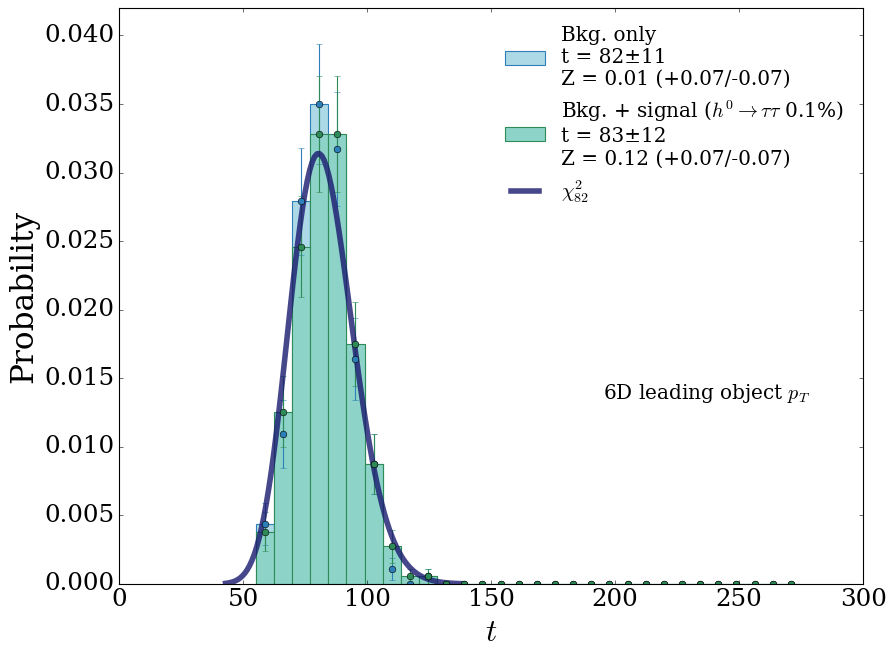

[1. 2. 3.] [0.2, 0.052, 0.004] [(0.02584, 0.02423), (0.01397, 0.01354), (0.0033, 0.0033)]
[1. 2. 3.] [0.164, 0.016, 0.0] [(0.02381, 0.02249), (0.00761, 0.00748), (nan, nan)]
1.0
(0.02584, 0.02423)
0.02
2.0000000000000004
(0.01397, 0.01354)
0.01
2.9999999999999982
(0.0033, 0.0033)
0.0


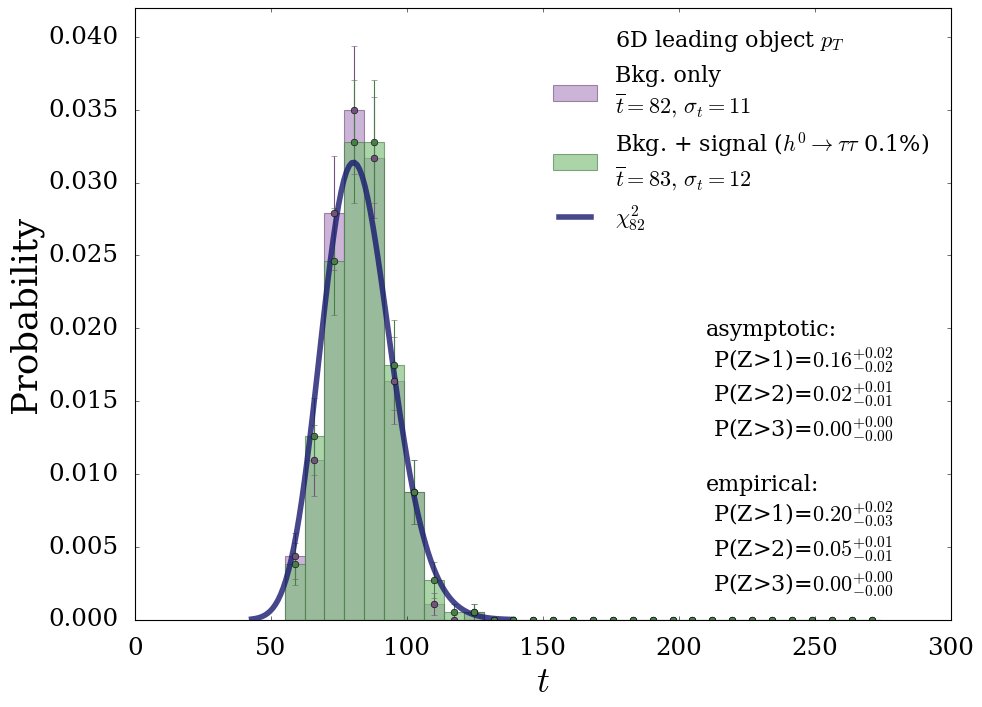

In [650]:
df = np.mean(t0)
xmax = np.max(t1)+150
xmin = np.min(t0)
signal_type = 7 #Signal type (see signal_type_dict)
injection_rate = 0.1 #Signal injection in percent
embedding_type = r"6D leading object $p_T$" # 6D self-supervised , 6D supervised , 57D source, r"6D leading object $p_T$"
save_name = f"SIG{signal_type}-{injection_rate*1000}-6DleadingobjectpT"
z_as, z_em, p_as = plot_2distribution(t0, t1, df, xmin=xmin, xmax=xmax, ymax=None, nbins=30, 
                   save=False, output_path='savefigs_paper', label1="Bkg. only", label2="Bkg. + signal", save_name=save_name, print_Zscore=True, signal_type=signal_type, injection_ratio=injection_rate, embedding_type=embedding_type)
_, _ = plot_2distribution_new(t0, t1, df, xmin=xmin, xmax=xmax, ymax=None, nbins=30, return_power=True, save=True, output_path='savefigs_paper', label1="Bkg. only", label2="Bkg. + signal", save_name=save_name, print_Zscore=True, signal_type=signal_type, injection_ratio=injection_rate, embedding_type=embedding_type)

In [6]:
print(f"Z-score asymptotic: {z_as[0],z_as[1]-z_as[0],z_as[0]-z_as[2]}")
print(f"Z-score empirical: {z_em[0],z_em[1]-z_em[0],z_em[0]-z_em[2]}")
print(f"p-value asymptotic: {p_as[0],-(p_as[0]-p_as[1]),(p_as[2]-p_as[0])}")

Z-score asymptotic: (5.980794788269215, 0.0930463053601569, 0.0937671547118919)
Z-score empirical: (2.6520698079021954, inf, 0.24315426208673419)
p-value asymptotic: (1.1102573788472746e-09, -4.858258043387268e-10, 8.55757574719076e-10)
